In [20]:
# Step 1: Import Required Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight

In [21]:
data_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
val_dir = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'
classes = os.listdir(data_dir)


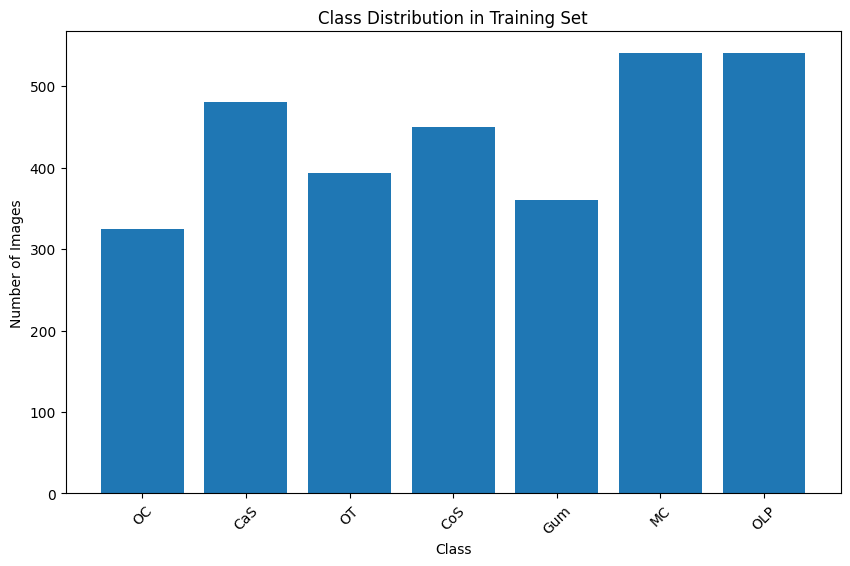

In [22]:
class_counts = [len(os.listdir(os.path.join(data_dir, cls))) for cls in classes]

plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [24]:
# Step 3: Data Preprocessing and Augmentation
# Constants
IMG_SIZE = (256, 256)  # Resize images to 256x256
BATCH_SIZE = 32
EPOCHS = 50

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0,  # Black padding for dental images
    validation_split=0.2
)

# Validation data (only normalization)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Data generators
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2471 images belonging to 7 classes.
Found 204 images belonging to 7 classes.


Found 3087 images belonging to 7 classes.


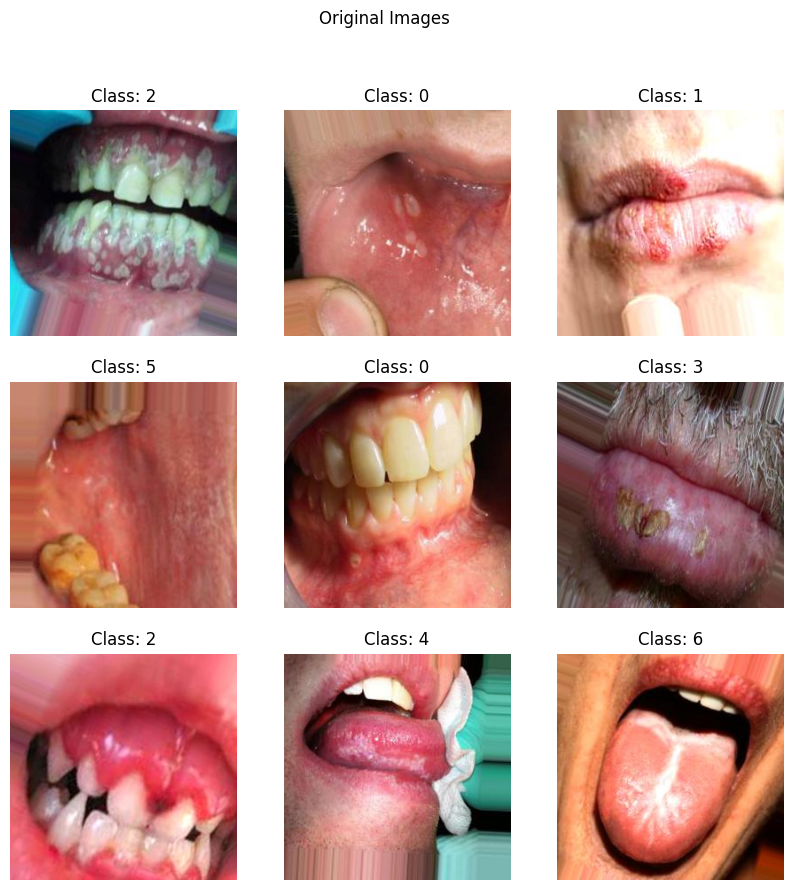

Found 3087 images belonging to 7 classes.


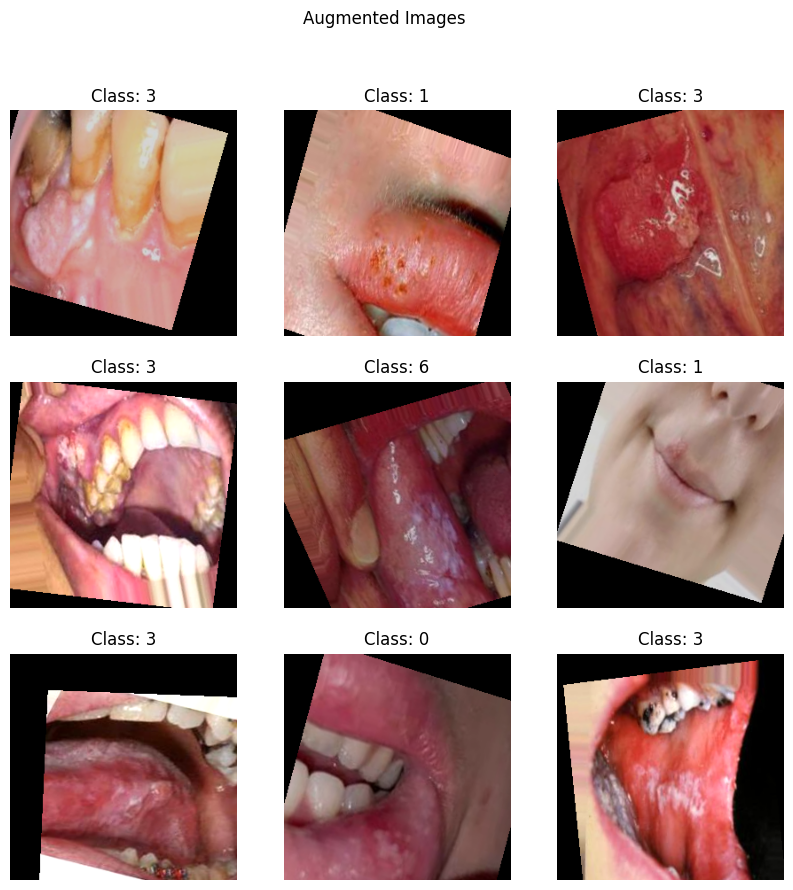

In [25]:
# Step 4: Visualize Augmented Images
def plot_augmented_images(generator, title):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Class: {np.argmax(labels[i])}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize original images
original_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(data_dir, batch_size=BATCH_SIZE)
plot_augmented_images(original_generator, 'Original Images')

# Visualize augmented images
augmented_generator = train_datagen.flow_from_directory(data_dir, batch_size=BATCH_SIZE)
plot_augmented_images(augmented_generator, 'Augmented Images')

In [26]:
# Step 5: Build DenseNet Model from Scratch
def build_densenet_model(input_shape=(256, 256, 3), num_classes=7):
    # Use DenseNet121 architecture without pre-trained weights
    base_model = DenseNet201(
        include_top=False,
        weights=None,  # Train from scratch
        input_shape=input_shape
    )
    
    # Add custom head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Compile the model
model = build_densenet_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 262, 262, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 64, 64, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 64, 64, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 64, 64, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 19,316,807 (73.69 MB)

 Trainable params: 19,083,911 (72.80 MB)

 Non-trainable params: 232,896 (909.75 KB)

In [27]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE,
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 568s 3s/step - accuracy: 0.2280 - loss: 2.5168 - val_accuracy: 0.1198 - val_loss: 2.0179
Epoch 2/50
 1/77 ━━━━━━━━━━━━━━━━━━━━ 26s 343ms/step - accuracy: 0.3750 - loss: 1.7643

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.3750 - loss: 1.7643 - val_accuracy: 0.3333 - val_loss: 1.9182
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 480ms/step - accuracy: 0.3640 - loss: 2.0290 - val_accuracy: 0.0938 - val_loss: 2.1021
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3750 - loss: 1.5971 - val_accuracy: 0.2500 - val_loss: 1.8330
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 487ms/step - accuracy: 0.3676 - loss: 1.8206 - val_accuracy: 0.1354 - val_loss: 2.4166
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.1133 - val_accuracy: 0.0833 - val_loss: 2.2736
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 41s 481ms/step - accuracy: 0.4335 - loss: 1.6613 - val_accuracy: 0.2031 - val_loss: 2.6635
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5938 - loss: 1.1549 - val_accuracy: 0.0833 - val_loss: 2.1626
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 40s 474ms/step - accuracy: 0.4017 - loss: 1.6878 - val_accuracy: 0.2552 - val_l

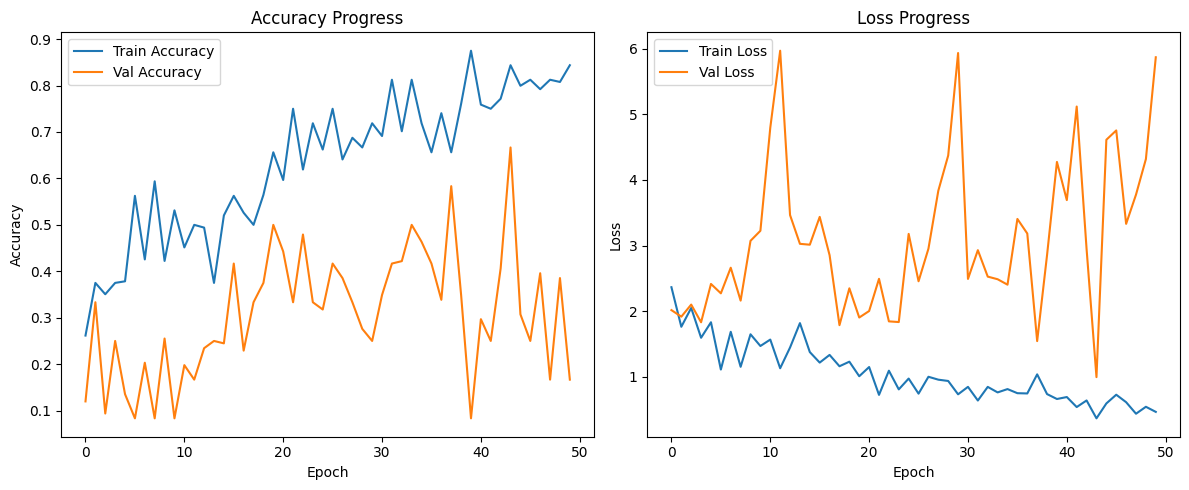

In [28]:
# Step 8: Evaluate Training Progress
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Progress')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save('/kaggle/working/teeth_classification_model.h5')